In [5]:
#Import localizations from hdf5 data
import h5py as _h5py
import numpy as _np
import yaml as _yaml
import os.path as _ospath
import numpy as np
import pandas as pd
import glob, os
from scipy.spatial import distance
import matplotlib as mpl
import matplotlib.pyplot as plt

def loadlocs(path):    
    with _h5py.File(path, 'r') as locs_file:
        locs = locs_file['locs'][...]
    locs = _np.rec.array(locs, dtype=locs.dtype)    # Convert to rec array with fields as attributes
    return locs

def isolate_slice(locs,center_x,center_y,radius,thickness):
    
    index_big = np.sqrt(np.square(locs['x']-center_x) + np.square(locs['y']-center_y)) <=radius
    index_small = np.sqrt(np.square(locs['x']-center_x) + np.square(locs['y']-center_y)) < (radius-thickness)
    
    index_all = index_big & ~index_small
    
    slicelocs = locs[index_all]
    
    return slicelocs

def save_locs(path, locs):
    with _h5py.File(path,'w') as locs_file:
        locs_file.create_dataset('locs', data=locs)
    base, ext = _ospath.splitext(path)


In [6]:
#Define settings

path = './X67_X71.hdf5'
img_size_x = 512
img_size_y = 512

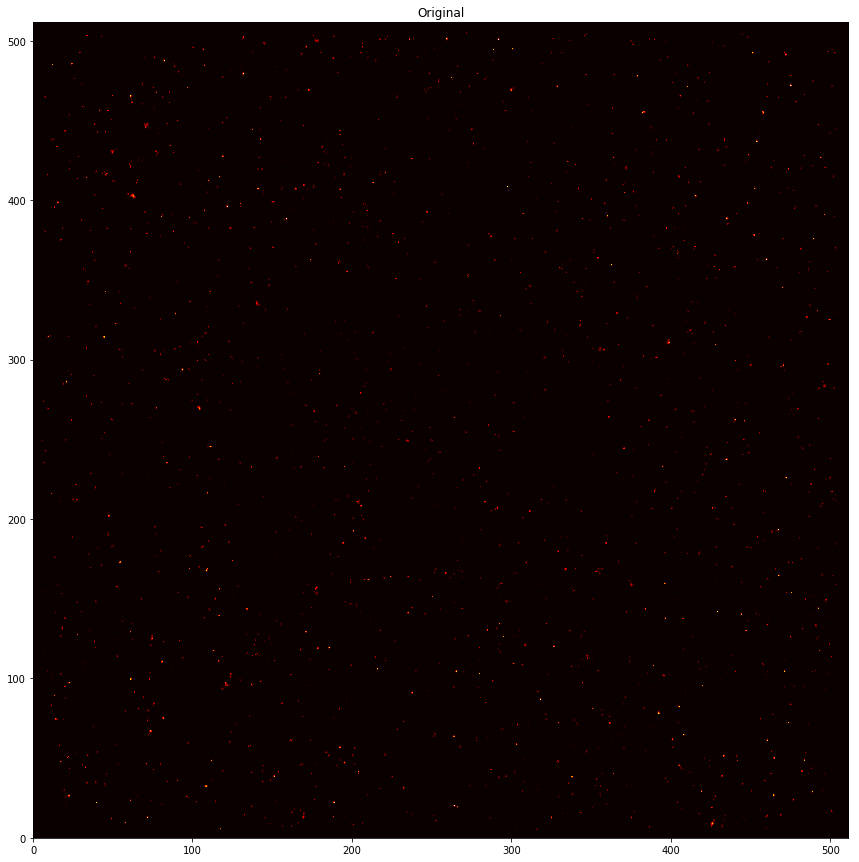

In [7]:
#Load and display locs

locs = loadlocs(path)

xedges = np.arange(0,img_size_x,0.5)
yedges = np.arange(0,img_size_y,0.5)

H, xedges, yedges = np.histogram2d(locs['x'], locs['y'], bins=(xedges, yedges))
H = H.T  # Let each row list bins with common y range.
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(111, title='Original')
plt.imshow(H, cmap='hot',interpolation='nearest', origin='low',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.show()

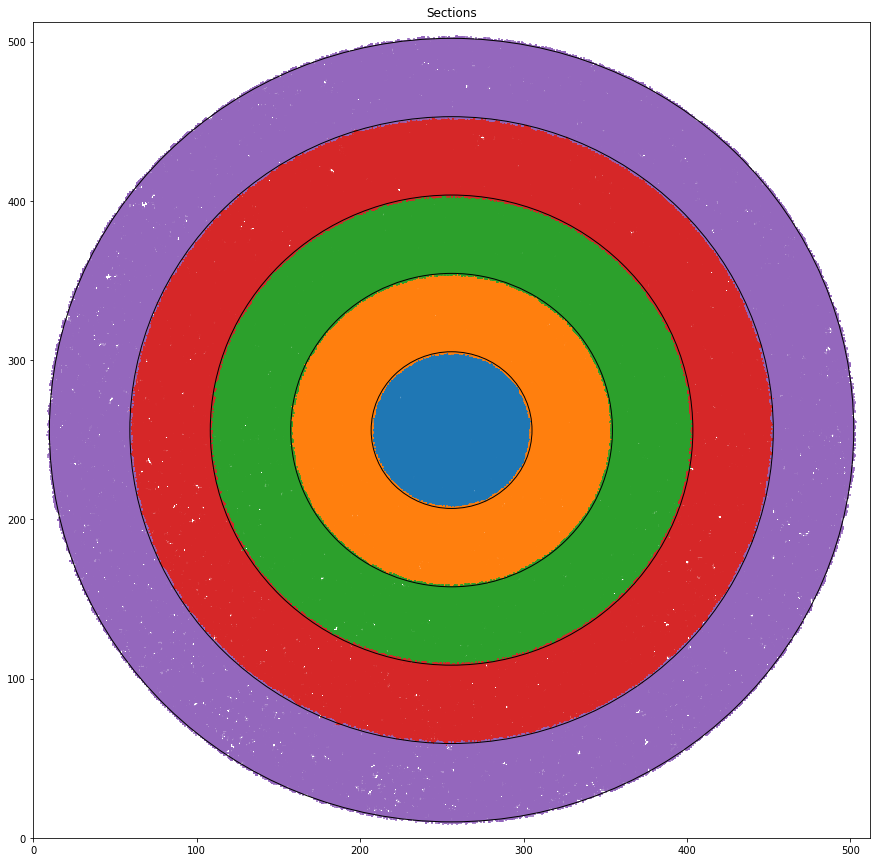

In [8]:
#Isolate sliecs

sphere_radius = (img_size_x)/2 
sections = 5
thickness = (sphere_radius-10)/sections #subtract 5 pixels as there are no locs on the edge

all_radii = np.arange(thickness,sphere_radius,thickness)

center_x = img_size_x/2
center_y = img_size_x/2

fig2 = plt.figure(figsize=(15, 15))
ax1 = fig2.add_subplot(111, title='Sections')

df_rlocs = pd.DataFrame()

r_id = 0

for r in all_radii:

    c = plt.Circle((center_x, center_y), r, linewidth=1, fill=False)
    ax1.add_patch(c)
    slicelocs = isolate_slice(locs,center_x,center_y,r,thickness)    
    plt.scatter(slicelocs['x'],slicelocs['y'],marker='+')
    
    df_slicelocs = pd.DataFrame(slicelocs)
    df_slicelocs['r_id'] = r_id
    
    df_rlocs = df_rlocs.append(df_slicelocs)
    
    #Save locs
    save_locs('./X67_X71_'+str(r_id)+'.hdf5',slicelocs)
    
    r_id = r_id + 1
    
plt.xlim((0, img_size_x))
plt.ylim((0, img_size_y))
plt.show()